# Tree-based ML and Feature Selection

**This week, your assignment is:**

- use our prepared churn data from week 2
- break our data into features and targets, and train and test sets
- use sklearn to fit a decision tree to the training data
    - plot the decision tree
    - change the max_depth of the decision tree to improve the model if needed (or tune it with a hyperparameter search)
- plot the correlations between features and targets
- use sklearn to fit a random forest model to predict churn from our dataset
    - plot the feature importances from the random forest
- choose some of the less-important features to remove from the model using feature importances and correlations and fit the random forest model to the new data
    - examine the feature importances after removing less important features
- write a short analysis of the results of your work


***Optional* advanced tasks:**
- use H2O to fit a random forest to our original, unmodified data (missing values and all)
    - you can decide if you want to break the data into train and test sets or not, but remember it's best to evaluate performance on a test or validation dataset
    - plot the H2O random forest's feature importances
- tune the random forest hyperparameters for the sklearn and/or H2O models
- use forward and/or backward selection with feature importances from a random forest model
- use recursive feature selection
- compare the various feature selection methods you tried and write a short summary

## Decision Trees

In [1]:
# Import the libraries that we are going to use and setup matplotlib as inline for display on my local Jupyter Notebook

%matplotlib inline
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import math
import seaborn as sns
from scikitplot.estimators import plot_feature_importances

# Import libraries for the optional section
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import phik

In [2]:
df = pd.read_csv('prepped_churn_data.csv', index_col='customerID')
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,AutoPay,Churn
customerID,,,,,,,,
7590-VHVEG,1,0,0,0,29.85,29.85,0,0
5575-GNVDE,34,1,1,1,56.95,1889.50,0,0
3668-QPYBK,2,1,0,1,53.85,108.15,0,1
7795-CFOCW,45,0,1,2,42.30,1840.75,1,0
9237-HQITU,2,1,0,0,70.70,151.65,0,1
...,...,...,...,...,...,...,...,...
6840-RESVB,24,1,1,1,84.80,1990.50,0,0
2234-XADUH,72,1,1,3,103.20,7362.90,1,0
4801-JZAZL,11,0,0,0,29.60,346.45,0,0


In [3]:
features = df.drop('Churn', axis=1)
targets = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

In [4]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.993563044301401
0.7155025553662692


That first training accuracy of 99% looks like some extreme overfitting here, especially since our test sample accuracy is only 71%.

In [5]:
dt.get_depth()

26

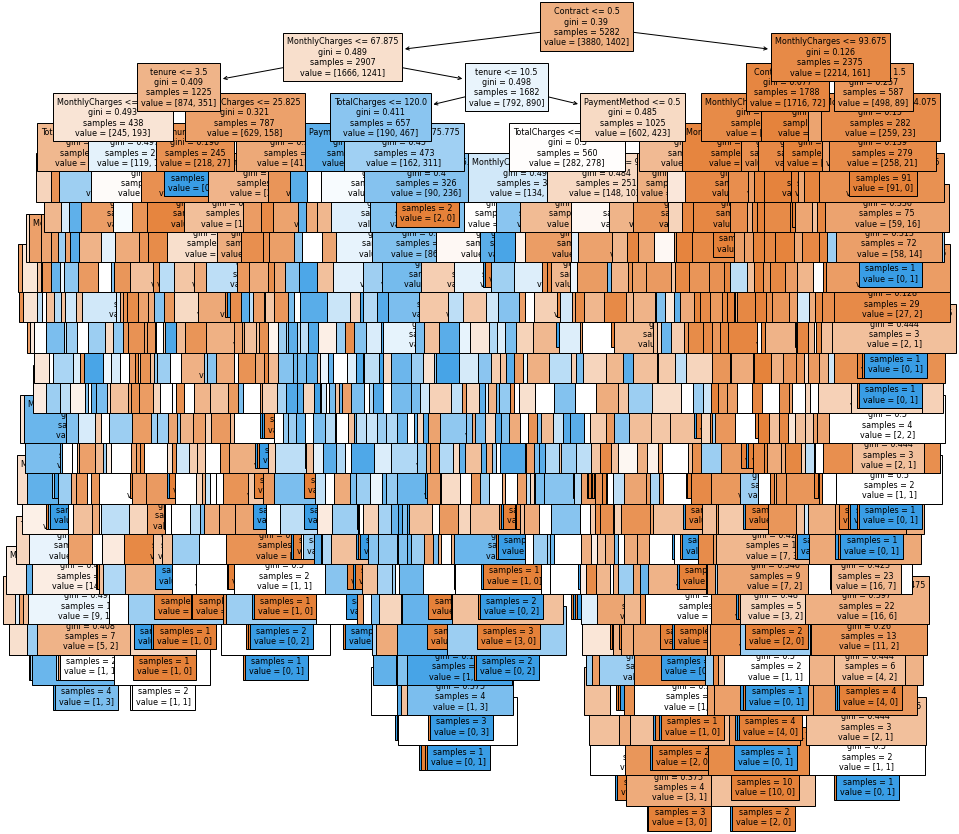

In [6]:
f = plt.figure(figsize=(15, 15))
_ = plot_tree(dt, fontsize=8, feature_names=features.columns, filled=True)

In [7]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.7531238167360849
0.7444633730834753


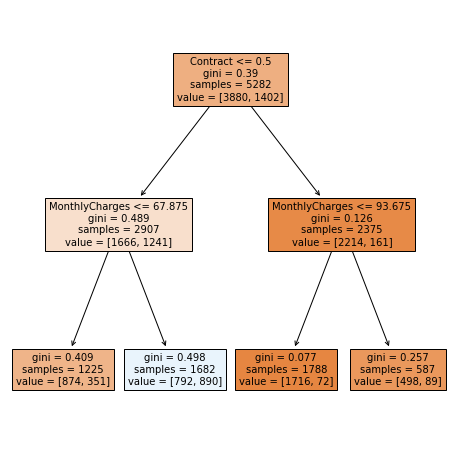

In [8]:
f = plt.figure(figsize=(8, 8))
_ = plot_tree(dt, fontsize=10, feature_names=features.columns, filled=True)

## Random Forests

In [9]:
# Using the RandomForestClassifier from sklearn

rfc = RandomForestClassifier(max_depth=5, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.8055660734570238
0.7950028392958546


In [10]:
# Same classifier but decreasing the max depth of the trees used

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.7678909503975767
0.7666098807495741


In [11]:
math.sqrt(x_train.shape[1])

2.6457513110645907

In [12]:
rfc = RandomForestClassifier(max_depth=2, max_features=7, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.7540704278682318
0.747870528109029


<AxesSubplot:>

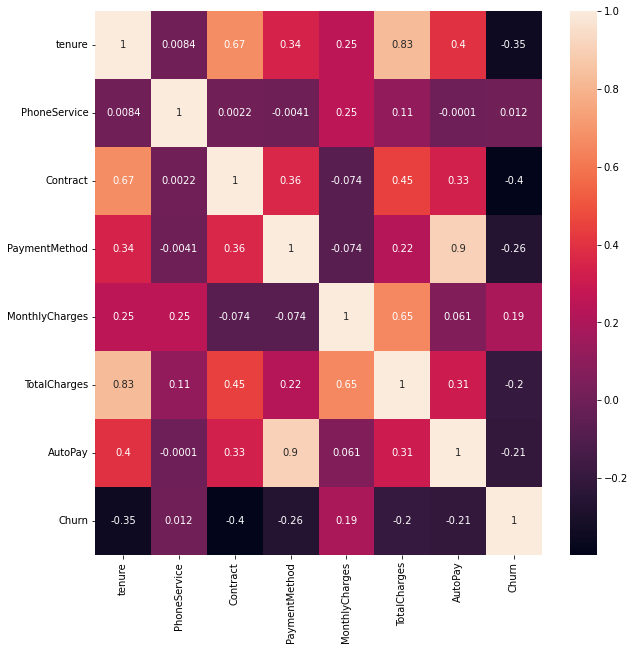

In [13]:
f = plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:title={'center':'Feature Importance'}>

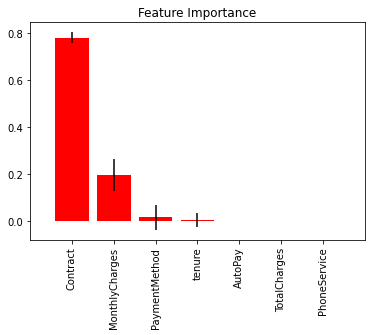

In [14]:
# Let's see what features are important for these decision trees and random forests

plot_feature_importances(rfc, feature_names=features.columns, x_tick_rotation=90)

In [15]:
new_features = features.drop(['AutoPay', 'TotalCharges', 'PhoneService'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(new_features, targets, stratify=targets, random_state=42)

In [16]:
rfc = RandomForestClassifier(max_depth=2, max_features=4, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.7540704278682318
0.747870528109029


<AxesSubplot:title={'center':'Feature Importance'}>

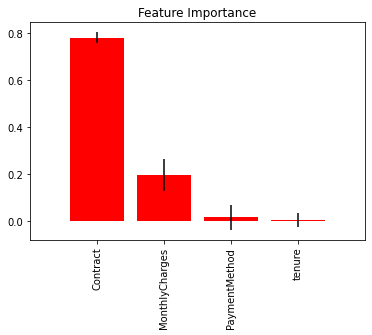

In [17]:
plot_feature_importances(rfc, feature_names=new_features.columns, x_tick_rotation=90)

## H2O

In [18]:
# Starting the h2o package

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/tosterberg/.local/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt_1wvi1d
  JVM stdout: /tmp/tmpt_1wvi1d/h2o_tosterberg_started_from_python.out
  JVM stderr: /tmp/tmpt_1wvi1d/h2o_tosterberg_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_tosterberg_jqgbb9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.70 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


In [19]:
# importing the unprepped csv of the churn data

hf = h2o.H2OFrame(pd.read_csv('churn_data.csv', index_col='customerID'))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
hf

tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,No,Month-to-month,Electronic check,29.85,29.85,No
34,Yes,One year,Mailed check,56.95,1889.5,No
2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
45,No,One year,Bank transfer (automatic),42.3,1840.75,No
2,Yes,Month-to-month,Electronic check,70.7,151.65,Yes
8,Yes,Month-to-month,Electronic check,99.65,820.5,Yes
22,Yes,Month-to-month,Credit card (automatic),89.1,1949.4,No
10,No,Month-to-month,Mailed check,29.75,301.9,No
28,Yes,Month-to-month,Electronic check,104.8,3046.05,Yes
62,Yes,One year,Bank transfer (automatic),56.15,3487.95,No


In [21]:
hf.types

{'tenure': 'int',
 'PhoneService': 'enum',
 'Contract': 'enum',
 'PaymentMethod': 'enum',
 'MonthlyCharges': 'real',
 'TotalCharges': 'real',
 'Churn': 'enum'}

In [22]:
# Decompose columns to features and target

predictors = hf.columns
predictors.remove('Churn')
response = 'Churn'

# Split the dataset into a train and valid set:
train, valid = hf.split_frame(ratios=[.8], seed=1234, )

# Build and train the model:
drf = H2ORandomForestEstimator(ntrees=50,
                                    max_depth=2,
                                    calibrate_model=True,
                                    calibration_frame=valid)
drf.train(x=predictors,
           y=response,
           training_frame=train,
           validation_frame=valid)

# Eval performance:
perf = drf.model_performance(valid=valid)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [23]:
perf


ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.1494991609854289
RMSE: 0.38665121360915045
LogLoss: 0.45760026834102774
Mean Per-Class Error: 0.2509203052244082
AUC: 0.8227433899195765
AUCPR: 0.6144430359821664
Gini: 0.645486779839153

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3552760052680969: 


,,No,Yes,Error,Rate
0,No,798.0,219.0,0.2153,(219.0/1017.0)
1,Yes,104.0,259.0,0.2865,(104.0/363.0)
2,Total,902.0,478.0,0.2341,(323.0/1380.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.355276,0.615933,59.0
1,max f2,0.187631,0.746596,119.0
2,max f0point5,0.458402,0.576430,22.0
3,max accuracy,0.458402,0.786232,22.0
4,max precision,0.574952,0.941176,0.0
5,max recall,0.091025,1.000000,178.0
6,max specificity,0.574952,0.998033,0.0
7,max absolute_mcc,0.355276,0.460962,59.0
8,max min_per_class_accuracy,0.323399,0.741047,74.0
9,max mean_per_class_accuracy,0.345833,0.750165,63.0



Gains/Lift Table: Avg response rate: 26.30 %, avg score: 26.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.024638,0.574952,3.578026,3.578026,0.941176,0.574952,0.941176,0.574952,0.088154,0.088154,257.802625,257.802625,0.086188
1,2,0.032609,0.567904,2.419234,3.294766,0.636364,0.567904,0.866667,0.573229,0.019284,0.107438,141.923366,229.476584,0.101538
2,3,0.050725,0.536378,2.889256,3.149941,0.760000,0.537369,0.828571,0.560422,0.052342,0.159780,188.925620,214.994097,0.147980
3,4,0.102899,0.519070,2.059229,2.596904,0.541667,0.520212,0.683099,0.540034,0.107438,0.267218,105.922865,159.690374,0.222970
4,5,0.150000,0.451655,2.222505,2.479339,0.584615,0.488357,0.652174,0.523807,0.104683,0.371901,122.250477,147.933884,0.301104
5,6,0.205797,0.403288,1.629280,2.248865,0.428571,0.414790,0.591549,0.494249,0.090909,0.462810,62.927981,124.886509,0.348749
6,7,0.345652,0.356920,1.772792,2.056240,0.466321,0.371313,0.540881,0.444508,0.247934,0.710744,77.279150,105.623993,0.495405
7,8,0.400000,0.311669,0.912397,1.900826,0.240000,0.329391,0.500000,0.428867,0.049587,0.760331,-8.760331,90.082645,0.488944
8,9,0.506522,0.276616,1.034463,1.718630,0.272109,0.289041,0.452074,0.399462,0.110193,0.870523,3.446337,71.862992,0.493926
9,10,0.604348,0.185100,0.675849,1.549835,0.177778,0.222680,0.407674,0.370846,0.066116,0.936639,-32.415060,54.983451,0.450897


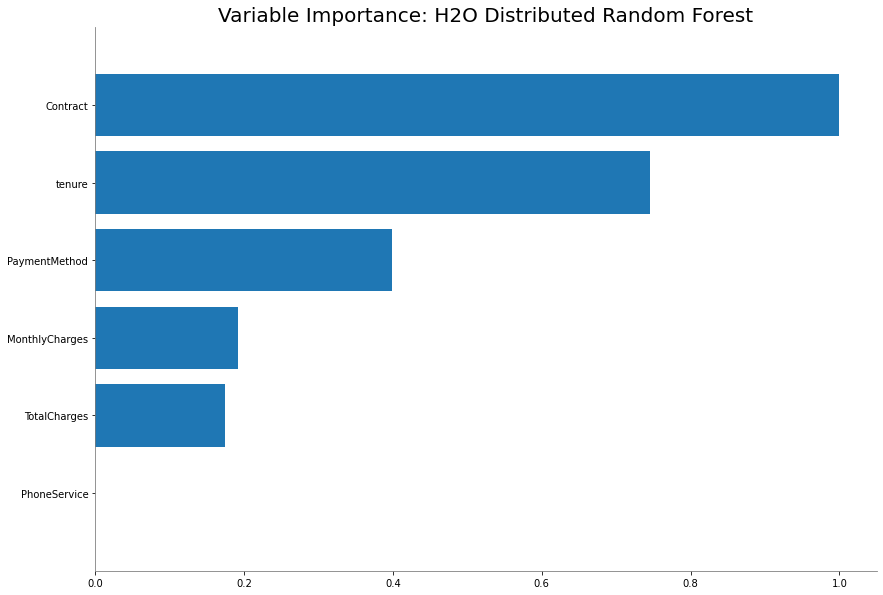

<Figure size 432x288 with 0 Axes>

In [24]:
drf.varimp_plot(num_of_features=features.shape[1])

In [33]:
# Hyperparamter tuning using grid search in h2o in conjunction with randomforestclassifiers
h2o.init()

# Decompose columns to features and target
predictors = hf.columns
predictors.remove('Churn')
response = 'Churn'

# Split the dataset into a train and valid set:
train, valid = hf.split_frame(ratios=[.8], seed=1234, )

# Setup hyper parameters and grid search
drf_hyper_params = {
    "ntrees": [25,50,100],
    "max_depth": [2,5,7],
    "sample_rate": [0.5,0.75,1.0]
}

grid_search_criteria = {
    "strategy": "RandomDiscrete",
    "max_models": 100,
    "seed": 1234
}

# Build and train the model:
churn_drf_grid = H2OGridSearch(model=H2ORandomForestEstimator(seed=1234,
                                                              nfolds=5,
                                                              fold_assignment="Modulo",
                                                              keep_cross_validation_predictions=True),
                              hyper_params=drf_hyper_params,
                              search_criteria=grid_search_criteria,
                              grid_id="churn_drf_grid")

churn_drf_grid.train(x=predictors, y=response, training_frame=train)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 06 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_tosterberg_jqgbb9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.59 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
      max_depth  ntrees  sample_rate                model_ids   logloss
0           7.0   100.0         0.75  churn_drf_grid_model_24  0.426343
1           7.0   100.0         0.75  churn_drf_grid_model_51  0.426343
2           7.0   100.0         1.00   churn_drf_grid_model_1  0.426658
3           7.0   100.0         1.00  churn_drf_grid_model_28  0.426658
4           7.0    50.0         1.00  churn_drf_grid_model_32  0.426745
5           7.0    50.0         1.00   churn_drf_grid_model_5  0.426745
6           7.0   100.0         0.50  churn_drf_grid_model_13  0.427128
7           7.0   100.0         0.50  churn_drf_grid_model_40  0.427128
8           7.0    50.0         0.75  churn_drf_grid_model_27  0.427461
9           7.0    50.0         0.75  churn_drf_grid_model_54  0.427461
10          7.0    25.0         1.00  churn_drf_grid_model_10  0.427907
11          7.0    25.0         1.00  chu

In [34]:
def get_best_model(grid):
    aucs = []
    for model in grid:
        if not(model.auc() == 'NaN'):
            aucs.append(model.auc())
        else:
            aucs.append(0.0)
    max_idx = aucs.index(max(aucs))
    best_model = grid[max_idx]
    return best_model

In [39]:
grid_best_model = get_best_model(churn_drf_grid)
grid_best_model.model_id

'churn_drf_grid_model_15'

In [38]:
perf = grid_best_model.model_performance(valid=valid)
perf


ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.13284725494220376
RMSE: 0.3644821736960585
LogLoss: 0.4085136400359427
Mean Per-Class Error: 0.23134401131183108
AUC: 0.8504839220848875
AUCPR: 0.6784713639278708
Gini: 0.7009678441697751

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33493690311908725: 


,,No,Yes,Error,Rate
0,No,807.0,210.0,0.2065,(210.0/1017.0)
1,Yes,93.0,270.0,0.2562,(93.0/363.0)
2,Total,900.0,480.0,0.2196,(303.0/1380.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.334937,0.640569,196.0
1,max f2,0.157503,0.754039,288.0
2,max f0point5,0.515992,0.634629,115.0
3,max accuracy,0.515992,0.806522,115.0
4,max precision,0.871563,1.000000,0.0
5,max recall,0.016150,1.000000,386.0
6,max specificity,0.871563,1.000000,0.0
7,max absolute_mcc,0.375382,0.501789,174.0
8,max min_per_class_accuracy,0.315067,0.760079,206.0
9,max mean_per_class_accuracy,0.245337,0.773211,239.0



Gains/Lift Table: Avg response rate: 26.30 %, avg score: 26.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010145,0.817322,3.801653,3.801653,1.000000,0.834350,1.000000,0.834350,0.038567,0.038567,280.165289,280.165289,0.038567
1,2,0.021014,0.790223,3.294766,3.539470,0.866667,0.803561,0.931034,0.818425,0.035813,0.074380,229.476584,253.946993,0.072414
2,3,0.030435,0.763140,3.216783,3.439591,0.846154,0.776508,0.904762,0.805451,0.030303,0.104683,221.678322,243.959071,0.100750
3,4,0.040580,0.739524,2.987013,3.326446,0.785714,0.751220,0.875000,0.791893,0.030303,0.134986,198.701299,232.644628,0.128103
4,5,0.050725,0.709248,2.987013,3.258560,0.785714,0.725316,0.857143,0.778578,0.030303,0.165289,198.701299,225.855962,0.155456
5,6,0.100000,0.627037,2.739426,3.002755,0.720588,0.660881,0.789855,0.720582,0.134986,0.300275,173.942635,200.275482,0.271760
6,7,0.150000,0.562232,2.258953,2.754821,0.594203,0.596891,0.724638,0.679352,0.112948,0.413223,125.895317,175.482094,0.357176
7,8,0.200725,0.489121,1.792208,2.511561,0.471429,0.524424,0.660650,0.640201,0.090909,0.504132,79.220779,151.156130,0.411704
8,9,0.300000,0.367124,1.748205,2.258953,0.459854,0.426871,0.594203,0.569606,0.173554,0.677686,74.820534,125.895317,0.512494
9,10,0.400000,0.293113,1.157025,1.983471,0.304348,0.331598,0.521739,0.510104,0.115702,0.793388,15.702479,98.347107,0.533801


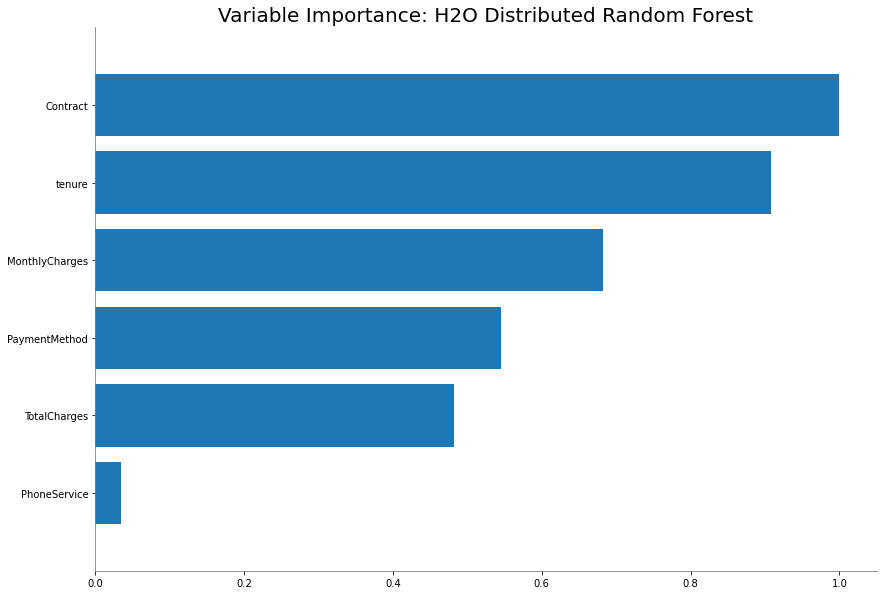

<Figure size 432x288 with 0 Axes>

In [40]:
grid_best_model.varimp_plot(num_of_features=features.shape[1])

## Phi-k

In [26]:
df.phik_matrix()

interval columns not set, guessing: ['tenure', 'PhoneService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'AutoPay', 'Churn']


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,AutoPay,Churn
tenure,1.000000,0.000000,0.664660,0.375115,0.411191,0.841370,0.519931,0.474001
PhoneService,0.000000,1.000000,0.000000,0.000000,0.831362,0.197616,0.000000,0.000000
Contract,0.664660,0.000000,1.000000,0.277462,0.388444,0.507723,0.202846,0.251639
PaymentMethod,0.375115,0.000000,0.277462,1.000000,0.399526,0.349474,1.000000,0.449125
MonthlyCharges,0.411191,0.831362,0.388444,0.399526,1.000000,0.762923,0.163649,0.360050
TotalCharges,0.841370,0.197616,0.507723,0.349474,0.762923,1.000000,0.420284,0.281437
AutoPay,0.519931,0.000000,0.202846,1.000000,0.163649,0.420284,1.000000,0.322809
Churn,0.474001,0.000000,0.251639,0.449125,0.360050,0.281437,0.322809,1.000000


interval columns not set, guessing: ['tenure', 'PhoneService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'AutoPay', 'Churn']


<AxesSubplot:>

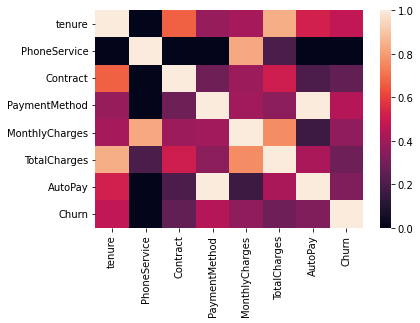

In [27]:
sns.heatmap(df.phik_matrix())

# Summary

This weeks work on the churn dataset has been focused on decision trees, random forests, and the h2o package.  I found this work to be very illuminating around feature importance and the GINI score in particular.  The very first decision tree that I made based off of the prepped churn data ended up being a nightmare of overfitting, and having to much maximum decision depth.  Once limiting the depth of the resulting tree we were able to come up with a decision tree that looked like a firm set of rules that would be implemented to categorize customers in an explainable way.  In this case, if the customer was part of payment method 0, and had a monthly charge of less than $67.88 then we would predict that they would churn with just under 75% accuracy.  After this we implemented a random forest classifier, which is an ensemble implementation that aggregates the outputs of many decision trees.  Finally we explored the h2o package, where we were able to put in the original churn data without prep and get a random forest classifier out.  I then decided to try implementing hyperparamter tuning using grid search on my h2o example and was able to show an improvement on our best model by AUC from the original .823 to .850 after tuning.  These projects showed some very interesting performance and explainability tradeoffs when using these methods, and the ease of hyper parameter tuning with h2o is an amazing level of automation for getting a high performance model ready quickly.